# Script to calibrate the gamma of a screen

In [1]:
from pyvstim.gui import VStimGUI
from pyvstim import getPreferences
from PyQt5.QtWidgets import QApplication
import numpy as np
import sys
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display

%gui qt5
user = 'joao'
prefs = getPreferences(user = user)
app = QApplication(sys.argv)
w = VStimGUI(app = app,expname = 'calibration', preferences = prefs)
w.show()

[19-10-17 14:06:46] - Opening GUI
[19-10-17 14:06:46] - Filename [run01_none.log] set
[19-10-17 14:06:46] - Initialized the logger controller.
[19-10-17 14:06:46] - Probed arduino on port COM15.
Window 0:  units: deg 
Warper was set on window 0.
	Screen is 191 by 107 deg.
Indicator duration: 0.951


c:\users\mouselab\lib\lineartreadmillrig\rig\widgets.py:303: RuntimeWarning: All-NaN slice encountered
  l = l[(~np.isnan(l)) & (l>np.nanmin(self.buf['position'][:,0]))]
c:\users\mouselab\lib\lineartreadmillrig\rig\widgets.py:303: RuntimeWarning: invalid value encountered in greater
  l = l[(~np.isnan(l)) & (l>np.nanmin(self.buf['position'][:,0]))]


VkJveChjaGlsZHJlbj0oRmxvYXRUZXh0KHZhbHVlPTAuMCwgZGVzY3JpcHRpb249dSdMdW1pbmFuY2U6JyksIEJvdW5kZWRGbG9hdFRleHQodmFsdWU9MS44LCBkZXNjcmlwdGlvbj11J0dhbW3igKY=


<IPython.core.display.Javascript object>


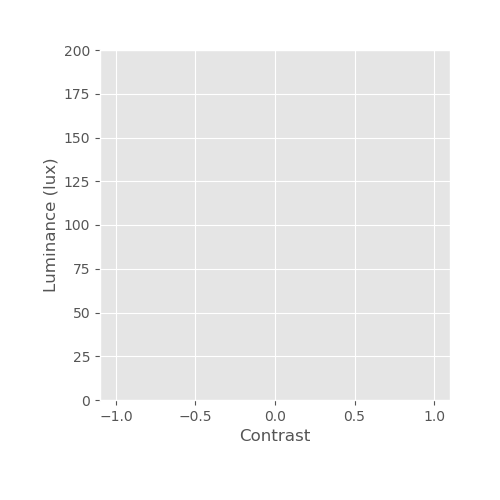

In [4]:
from time import sleep
import pylab as plt
# Set the screen to measure from
scrnidx = 0
gamma = 1.8
nMeasurements = 11 # Use an odd number

x = np.linspace(-1,1,nMeasurements)
lum = np.zeros_like(x)
win = w.exp.window[scrnidx]
win.setGamma(gamma)

# widgets
screenpar = dict(screen=scrnidx,
                 contrast=75,
                 brightness = 30)

text = widgets.FloatText(value=0,
                         description='Luminance:',
                         disabled=False)

gammatext = widgets.BoundedFloatText(value=gamma,
                                     min=0.5,
                                     max=2.0,
                                     step=0.1,
                                     description='Gamma:',
                                     disabled=False)
screenbrightnesstext = widgets.BoundedFloatText(value=screenpar['brightness'],
                                     min=0,
                                     max=100,
                                     step=1,
                                     description='Screen brightness:',
                                     disabled=False)
screencontrasttext = widgets.BoundedFloatText(value=screenpar['contrast'],
                                     min=0,
                                     max=100,
                                     step=1,
                                     description='Screen contrast:',
                                     disabled=False)

savebutton = widgets.Button(
    description='Fit and save',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Fit and save',
    icon='save'
)
xvalues = widgets.RadioButtons(
    options=x,
    value=x[0],
    description='Contrast values',
    disabled=False)

vbox=widgets.VBox(children=(text,gammatext,xvalues,
                            screenbrightnesstext,screencontrasttext,savebutton))

display(vbox)

def flip_value(val):
    win.setColor(val)
    win.setBuffer('right', clear=True)
    win.flip(clearBuffer=True)
def on_values(b):
    ii = np.where(x == xvalues.value)
    flip_value(x[ii])
def set_value(b):
    ii = np.where(x == xvalues.value)
    lum[ii] = text.value
    clumplot[0].set_ydata(lum)
    if np.sum(~np.isnan(lum)) > 2:
        ax.axis([-1.1,1.1,-0.1,np.nanmax(lum)*1.1 ])
def set_gamma(b):
    gamma = gammatext.value
    win.setGamma(gamma)
    #on_values(b)
def set_screenpar(b):
    screenpar['brightness'] = screenbrightnesstext.value
    screenpar['contrast'] = screencontrasttext.value
    
def fit_and_add_legend(b):
    ax.axis([-1.1,1.1,-0.1,np.nanmax(lum)*1.1 ])
    xx = np.linspace(-1,1,101)
    pfit = np.polyfit(x[~np.isnan(lum)],lum[~np.isnan(lum)],1)
    ax.plot(xx,np.polyval(pfit,xx))
    ax.text(0,np.polyval(pfit,0),'gray: {0:2.0f}'.format(np.polyval(pfit,0)),
           ha = 'right',va = 'bottom')
    ax.text(1,np.polyval(pfit,1),'max: {0:2.0f}'.format(np.polyval(pfit,1)),
           ha = 'right',va = 'bottom')

    ax.set_title('{0} - contrast:{1} bright:{2}'.format(win.monitor.name,
                                                        screenpar['contrast'],
                                                        screenpar['brightness']))
    from os.path import join as pjoin
    from datetime import datetime
    import os
    fname = pjoin(w.preferences['tmpFolder'],
              'calibrations',
              (datetime.strftime(datetime.today(),'%Y_%m_%d_')
               +win.monitor.name+'c{0}_b{1}.pdf'.format(screenpar['contrast'],
                                                screenpar['brightness'])))
    if not os.path.isdir(os.path.dirname(fname)):
        os.makedirs(os.path.dirname(fname))
    fig.savefig(fname)
    fname = fname.replace('.pdf','.txt')
    with open(fname,'w') as fd:
        for a,b in zip(x,lum):
            fd.write('{0},{1}\n'.format(a,b))
#figure
%matplotlib notebook
plt.matplotlib.style.use('ggplot')
fig = plt.figure(figsize = (5,5))
ax = fig.add_axes([0.2,0.2,0.7,0.7])
lum[:] = np.nan
# lum = luminvalus
clumplot = ax.plot(x,lum,'ko',markerfacecolor = 'none',markersize = 3)
ax.axis([-1.1,1.1,0,200])
ax.set_xlabel('Contrast')
ax.set_ylabel('Luminance (lux)')
gammas = []
contrasts = []
luminances = []
screenpars = []

flip_value(x[0])
savebutton.on_click(fit_and_add_legend)
text.observe(set_value)
gammatext.observe(set_gamma)
screencontrasttext.observe(set_screenpar)
screenbrightnesstext.observe(set_screenpar)
xvalues.observe(on_values)


In [13]:
w.exp.photosensorIndicator.setPos(np.array([635,-395]))
w.exp.photosensorIndicator.draw()
w.exp.window[0].flip()
w.exp.window[0].setBuffer('left',clear=True)

[18-06-19 20:10:17] - Closing connection to the rig and cleaning up screen.
Set logger exit flag.
Setting stop trigger.
Stopping rig.
[18-06-19 20:10:18] - Software stopped experiment [latency: 0.0000 s].
[18-06-19 20:10:20] - Software stopped experiment [latency: 0.0000 s].
Set logger exit flag.
Rig was already closed.
Closed window.
0.7580 	ERROR 	avbin.dll failed to load.
                     Try importing psychopy.visual as the first library
                     (before anything that uses scipy)
                     and make sure that avbin is installed.
0.7655 	ERROR 	avbin.dll failed to load.
                     Try importing psychopy.visual as the first library
                     (before anything that uses scipy)
                     and make sure that avbin is installed.
0.7870 	WARNING 	Movie2 stim could not be imported and won't be available
1.2872 	WARNING 	psychopy.parallel has been imported but no parallel port driver found. Install either input32 or dlportio


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [1]:
from pyvstim.mccdaq import MccdaqAnalogSample
daq = MccdaqAnalogSample(1,[0])
daq.start()
daq.event_trigger.set()

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
daq.event_trigger.clear()
daq.event_running.clear()

timer.stop()

<IPython.core.display.Javascript object>


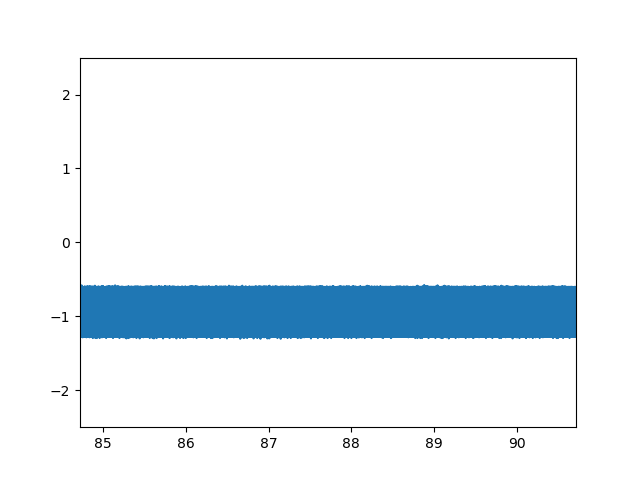

In [3]:
import pylab as plt
%matplotlib notebook
import numpy as np

fig, ax = plt.subplots()
dd = np.array([np.nan,np.nan])
global dat
dat = []
dplot = plt.plot(np.arange(len(dd))/10000.,dd)
plt.ylim([-2.5,2.5])
def update_title(axes):
    global dat
    while not daq.queue.empty():
        dat.append(daq.queue.get())
    dd = np.hstack(dat)
    dplot[0].set_ydata(dd)
    dplot[0].set_xdata(np.arange(len(dd))/10000.)
    ax.set_xlim([len(dd)/10000. - 6,len(dd)/10000.])
    fig.canvas.draw()

timer = fig.canvas.new_timer(interval=200)
timer.add_callback(update_title, ax)
timer.start()

# Create a new timer object. Set the interval to 100 milliseconds
# (1000 is default) and tell the timer what function should be called.

# Or could start the timer on first figure draw
#def start_timer(evt):
#    timer.start()
#    fig.canvas.mpl_disconnect(drawid)
#drawid = fig.canvas.mpl_connect('draw_event', start_timer)

plt.show()

<IPython.core.display.Javascript object>


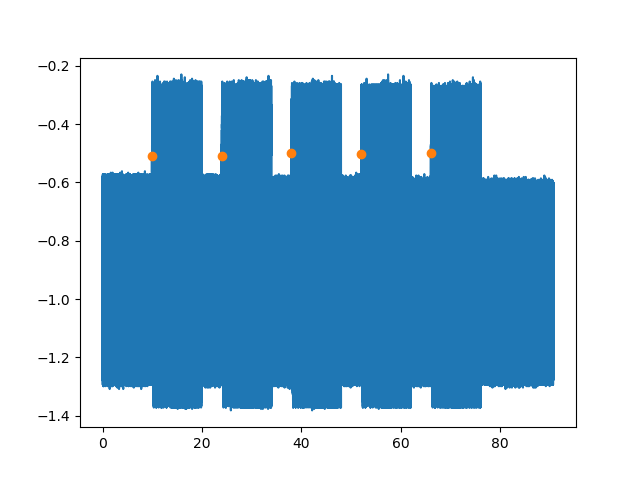

C:\Users\mouselab\vstim\joao\calibrations\gratings_chirpFullScreen_2018_08_20_samsung-syncmaster223360.0_log_min1_max32.npy


In [6]:
from datetime import datetime
import os
from os.path import join as pjoin
from pyvstim import getPreferences
p = getPreferences('joao')

fname = pjoin(p['tmpFolder'],
              'calibrations',
              'gratings_chirpFullScreen_'+(datetime.strftime(datetime.today(),'%Y_%m_%d_')
               +p['monitor'][0]['name']+'{0}_log_min1_max32.npy'.format(p['monitor'][0]['rate'])))
np.save(fname,np.hstack(dat))
dd = np.load(fname)
%matplotlib notebook
idx = np.where(np.diff(dd<np.mean(dd)*0.5))[0]
idx = idx[np.where(np.diff(np.hstack([0,idx]))>10000)]
tt = np.arange(len(dd))/1e4
plt.plot(tt,dd)
plt.plot(tt[idx],dd[idx],'o')
print(fname)

<IPython.core.display.Javascript object>


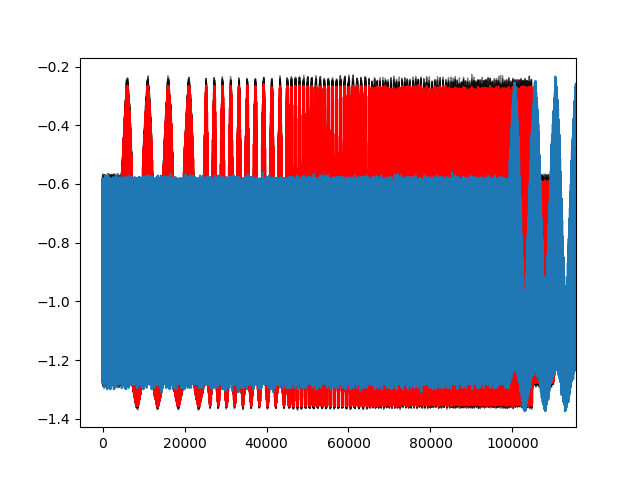

In [9]:
#get triggered traces
from scipy.signal import butter, filtfilt
duration = 10.
srate = 1e4
traces = []
tt = np.arange(-0.5*srate,(duration + 0.5)*srate).astype(int)
b, a = butter(8,5000./10000)
dd2 = filtfilt(b, a, dd, padlen=150)
for i in idx:
    traces.append(dd2[tt + i])
%matplotlib notebook
plt.plot(np.vstack(traces).T,color = 'k',alpha=0.5,lw = 1)
plt.plot(np.mean(np.vstack(traces).T,axis = 1),color = 'red')


<IPython.core.display.Javascript object>


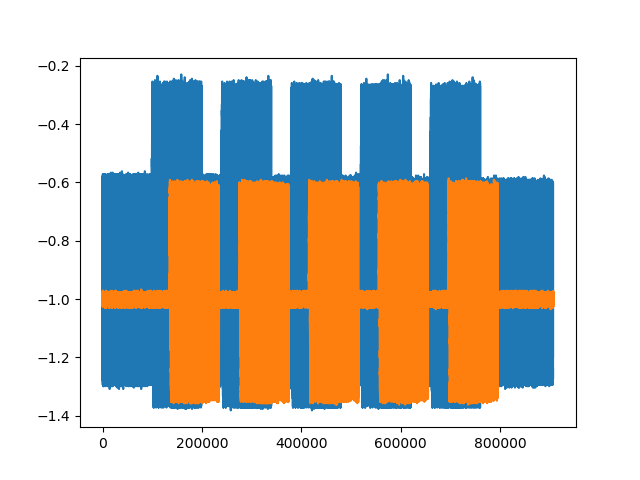

In [13]:
%matplotlib notebook
plt.plot(sam_dat)
plt.plot(asus_dat)

<IPython.core.display.Javascript object>


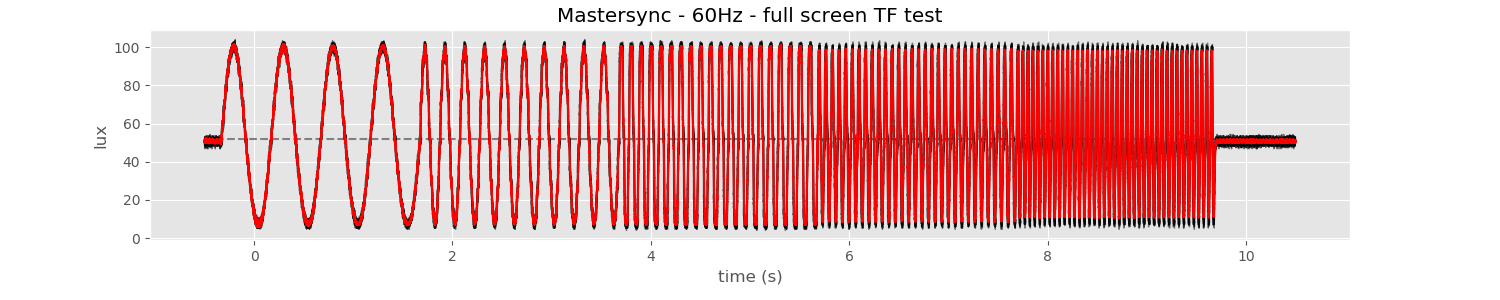

<IPython.core.display.Javascript object>


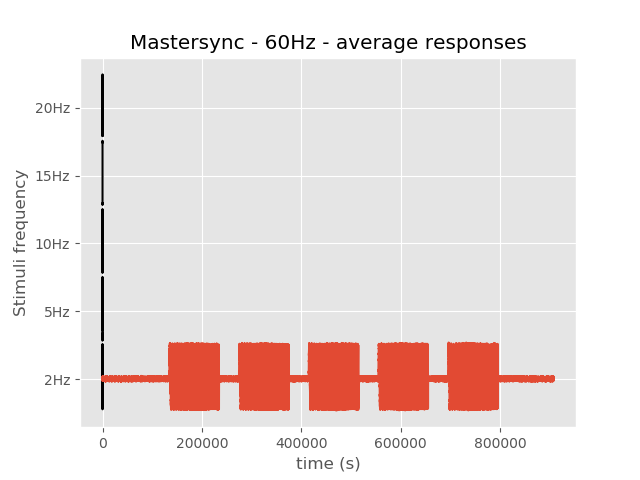

In [82]:
sam_dat = np.load('C:/Users/mouselab/vstim/joao/calibrations/gratings_chirpFullScreen_2018_08_20_samsung-syncmaster223360.0__2-5-10-15-20.npy')
asus_dat = np.load('C:/Users/mouselab/vstim/joao/calibrations/gratings_chirpFullScreen_2018_08_20_asus-pg27960.0_2-5-10-15-20.npy')
plt.matplotlib.style.use('ggplot')
from scipy.signal import butter, filtfilt
duration = 10.
srate = 1e4
traces = []
tt = np.arange(-0.5*srate,(duration + 0.5)*srate).astype(int)
dd = sam_dat
dd = asus_dat
minlux = 4
maxlux = 97 # asus
maxlux = 104
dd -= np.min(dd)
dd /= np.max(dd)
dd *= maxlux-minlux
dd += minlux
idx = np.where(np.diff(dd>np.mean(dd)*0.2))[0]
idx = idx[np.where(np.diff(np.hstack([0,idx]))>10000)]
for i in idx:
    traces.append(dd[tt + i])
%matplotlib notebook
fig = plt.figure(figsize=[15,3])
fig.add_axes([0.1,0.2,0.8,0.7])
t = tt/srate
mm  = np.mean(np.vstack(traces).T,axis = 1)
plt.plot(t,np.vstack(traces).T,color = 'k',alpha=0.5,lw = 1)
plt.plot(t,mm,color = 'red')
plt.hlines(np.mean(mm),t[0],t[-1],color='gray',linestyle='--')
plt.ylabel('lux')
plt.xlabel('time (s)')
# plt.title('Asus P279 - 60Hz - full screen TF test')
plt.title('Mastersync - 60Hz - full screen TF test')
fname = pjoin(p['tmpFolder'],
              'calibrations',
              'chirpFullScreen_'+datetime.strftime(datetime.today(),'%Y_%m_%d_')+
                                  'asus-pg279'+'_traces.pdf')
fname = pjoin(p['tmpFolder'],
              'calibrations',
              'chirpFullScreen_'+datetime.strftime(datetime.today(),'%Y_%m_%d_')+
                                  'mastersync'+'_traces.pdf')
plt.savefig(fname)
plt.figure()
plt.plot(t[(t>0) & (t<1)],mm[(t>0) & (t<1)],'k')
plt.plot(t[(t>0) & (t<1)],100+mm[(t>2) & (t<3)],'k')
plt.plot(t[(t>0) & (t<1)],200+mm[(t>4) & (t<5)],'k')
plt.plot(t[(t>0) & (t<1)],300+mm[(t>5) & (t<6)],'k')
plt.plot(t[(t>0) & (t<1)],400+mm[(t>7) & (t<8)],'k')
plt.yticks([50,150,250,350,450],['{0}Hz'.format(a) for a in [2,5,10,15,20]])
plt.ylabel('Stimuli frequency')
plt.xlabel('time (s)')
# plt.title('Asus P279 - 60Hz - average responses')
plt.title('Mastersync - 60Hz - average responses')
# fname = pjoin(p['tmpFolder'],
#               'calibrations',
#               'chirpFullScreen_'+datetime.strftime(datetime.today(),'%Y_%m_%d_')
#                +'asus-pg279'+'_averages.pdf')
fname = pjoin(p['tmpFolder'],
              'calibrations',
              'chirpFullScreen_'+datetime.strftime(datetime.today(),'%Y_%m_%d_')
               +'mastersync'+'_averages.pdf')

plt.savefig(fname)

<IPython.core.display.Javascript object>


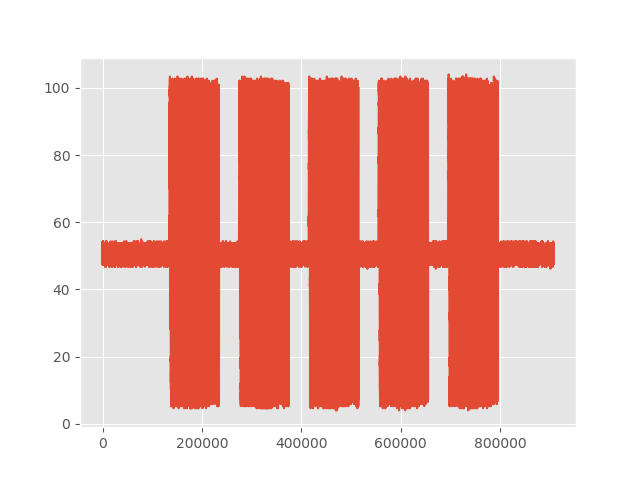

In [84]:
%matplotlib notebook
plt.plot(dd)

In [50]:
plt.hlines?